In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as sts
from scipy.optimize import brute
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import datetime as dt
import sklearn.linear_model as lin
from ast import literal_eval
from matplotlib import patches,colors
from matplotlib import rc,rcParams

timezoneoffset = 0 #set this to 0 if running in EST/New York
#timezoneoffset = -10800 #set this to 0 if running in EST/New York

direc = 'C:/Users/svo/Google Drive/Bas Games/Analysis/'
data_direc = 'C:/Users/svo/Google Drive/Bas Games/Data/'
fig_direc = 'C:/Users/svo/Google Drive/Bas Games/Figures/'

hist_direc = direc + 'Eye Movements/2_eye/histograms/'
model_direc = direc + 'Eye Movements/2_eye/Eye Movements/'
eye_direc = data_direc + '2_eye/Raw/Eye/'
game_direc = data_direc + '2_eye/Raw/Game/'



In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [3]:
def process_fix(line):
    x = np.array(line[6:].split()).astype(float)
    return np.vstack([x[[0,3,4]],x[[1,3,4]]])

def process_esacc(line):
    x = np.array(line[7:].split()).astype(float)
    return np.vstack([x[[0,3,4]],x[[1,5,6]]])
    
def get_offset(line):
    if line[:3]=='MSG':
        x = [int(i) for i in line[4:].split()]
        x[-1]*=1000
        print(x)
        return (dt(*x[1:]).timestamp() - x[0]/1000)
    else:
        return None

def load_asc_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        processed_lines = np.vstack([process_esacc(line) if line.startswith("ESACC") 
                                     else process_fix(line) if line.startswith("EFIX")
                                     else np.empty([0,3]) for line in lines])
        toffset = get_offset(lines[11])
        print(toffset)
        processed_lines[:,0] /= 1000
        processed_lines[:,0] += toffset + timezoneoffset
        return processed_lines

In [4]:
def process_game_line(line):
    line = line.replace("\"","").split(",")

def load_game_file(filename,col_names):
    d = pd.read_csv(filename,header=None, index_col=0, names = col_names)
    d.timestamp /= 1000
    return d.loc[d.rt>0]
    

In [5]:
fnames_eye = [os.path.join(eye_direc,f) for f in os.listdir(eye_direc) 
          if f.endswith('.asc') and not f.endswith('_fix.asc')]

eye_fix_saccs = [load_asc_file(f) for f in fnames_eye]

[688838, 2015, 4, 17, 14, 3, 4, 704000]
1429293095.866
[1378035, 2015, 4, 17, 12, 29, 20, 483000]
1429286782.448
[1388596, 2015, 4, 23, 13, 3, 38, 401000]
1429807229.805
[1097676, 2015, 4, 22, 11, 0, 42, 77000]
1429713744.4009998
[7251391, 2015, 4, 15, 13, 58, 0, 772000]
1429113429.381
[1845378, 2015, 4, 15, 12, 27, 55, 42000]
1429113429.664
[1251011, 2015, 4, 23, 10, 33, 8, 482000]
1429798337.4710002
[204223, 2015, 4, 17, 11, 9, 25, 39000]
1429283160.816
[933845, 2015, 4, 15, 10, 59, 47, 841000]
1429109053.996
[113189, 2015, 4, 24, 10, 47, 6, 168000]
1429886712.979


In [6]:
col_names = ['','initials','subject','gi','mi','status','bp','wp',
                     'move','rt','timestamp','mouse_t','mouse_coords']

fnames_game = [os.path.join(game_direc,f) for f in os.listdir(game_direc) 
          if f.endswith('.csv')]

data = [load_game_file(f,col_names) for f in fnames_game]
data_game = [d.loc[d.status.isin(['playing','win','draw'])].reset_index() for d in data]

In [7]:
actual_moves = [(np.array(list(d['move']))[None,:]==np.array(range(36))[:,None]).T for d in data_game]
black_pieces = [np.vstack([(list(dd['bp'])) for i,dd in d.iterrows()]).astype(int) for d in data_game]
white_pieces = [np.vstack([(list(dd['wp'])) for i,dd in d.iterrows()]).astype(int) for d in data_game]
black_pieces = [bp*(a==0) for bp,a in zip(black_pieces,actual_moves)]
white_pieces = [wp*(a==0) for wp,a in zip(white_pieces,actual_moves)]
occupied_squares = [bp + wp for bp,wp in zip(black_pieces,white_pieces)]

uniform_unocc=[(o==0)/np.sum(o==0,axis=1)[:,None] for o in occupied_squares]

In [8]:
def get_fractional_coord(dist_to_tcs,dist_between_tcs,main_tile,x):
    a=dist_to_tcs[main_tile]
    b=dist_between_tcs[main_tile,main_tile+x]
    c=dist_to_tcs[main_tile+x]
    return np.sign(x)*(a**2+b**2-c**2)/(2*b*b)

def get_absolute_smallest(x):
    return x[np.argmin(np.abs(x))]

def valid_shift(tile,d):
    return tile in range(36) and tile+d in range(36) and ((tile//9 == (tile+d)//9) or (tile%9 == (tile+d)%9))

def get_board_coords(eye_coords,eye_coords_tcs):
    dist_to_tcs = np.sqrt(np.sum((eye_coords[None,:]-eye_coords_tcs)**2,axis=1))
    dist_between_tcs= np.sqrt(np.sum((eye_coords_tcs[None,:,:]-eye_coords_tcs[:,None,:])**2,axis=2))
    main_tile = np.argmin(dist_to_tcs,axis=0)
    board_coords = [get_absolute_smallest([get_fractional_coord(dist_to_tcs,dist_between_tcs,main_tile,d)
                                           for d in dirs if valid_shift(main_tile,d)]) 
            for dirs in [[-1,1],[-9,9]]]
    if np.max(np.abs(board_coords))<=0.5:
        return np.array(board_coords)+[main_tile%9,main_tile//9]
    else:
        return np.empty(shape=(2,))*np.nan

def gaussian_filter(board_coords,sigma):
    x = np.arange(36)%9
    y = np.arange(36)//9
    return ((sts.norm.cdf(x+0.5,loc=board_coords[0],scale=sigma)-
             sts.norm.cdf(x-0.5,loc=board_coords[0],scale=sigma))
            *(sts.norm.cdf(y+0.5,loc=board_coords[1],scale=sigma)-
              sts.norm.cdf(y-0.5,loc=board_coords[1],scale=sigma)))
     
    
def get_eye_hist(e,t,dt,tile_coords,sigma):
    etdt = e[np.nonzero(e[:,0]>t)[0][0]-1:np.nonzero(e[:,0]<(t+dt))[0][-1]+1,:]
    if len(etdt)>1:
        durations = [etdt[1,0]-t] + list(np.diff(etdt[1:,0])) + [t+dt-etdt[-1,0]]
        board_coords = [get_board_coords(eye_coords[1:],np.array(tile_coords)) 
                        for eye_coords in etdt]
        h = np.sum([gaussian_filter(b,sigma)*d for b,d in zip(board_coords,durations)
                    if not np.any(np.isnan(b))],axis=0)
        if np.size(h) == 36:
            return h
        else: 
            return np.zeros(shape=(36,))
    else:
        return np.zeros(shape=(36,))
    
def get_all_hists(e,dgame,c,sigma):
    h = np.vstack([get_eye_hist(e,dd['timestamp'],dd['rt']/1000+0.5, c,sigma) 
                      for i,dd in dgame.iterrows()])
    print(h.shape)
    return h

def score_offset(toffset,e,ts,tile_ind):
    x = np.interp(ts,e[:,0]+toffset,e[:,1])
    y = np.interp(ts,e[:,0]+toffset,e[:,2])
    return np.abs(np.corrcoef(x,tile_ind%9))[0,1]+np.abs(np.corrcoef(y,tile_ind//9))[0,1]

def plot_voronoi(x,y,tile_coordinates,tile_ind,letter,xlim,ylim):
    fig,ax = plt.subplots(figsize=(6,4))
    voronoi_plot_2d(Voronoi(tile_coordinates),ax=ax,show_points = True,show_vertices = True,
                    line_colors = 'black', line_width =1, line_alpha = 1)
    ax.plot(x,y,'.',color='gray')
    for xx,yy,ti in zip(x,y,tile_ind):
        if xx>xlim[0] and xx<xlim[1] and yy>ylim[0] and yy<ylim[1]:
            ax.text(xx,yy,ti)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Horizontal eye position(a.u.)')
    ax.set_ylabel('Vertical eye position(a.u.)')
    ax.text(0.02, 0.9, letter, horizontalalignment='center',
        verticalalignment='center', transform=fig.transFigure, fontsize = 20)
    fig.tight_layout()
    fig.savefig(fig_direc + 'eye_calibration_' + letter + '.pdf')
    plt.show()


def calibrate(d,e,f,verbose=False):
    ts_game = d.loc[d.status=='eyecal'].timestamp
    tile_ind = d.loc[d.status=='eyecal'].move
    if f=='C:/Users/Bas/Google Drive/Bas Zahy Gianni - Games/Data/2_eye/Raw/Game/DL.csv':
        ts_game = ts_game[2:]
        tile_ind = tile_ind[2:]
    toffset = brute(lambda x: -score_offset(x,e,ts_game,tile_ind),ranges =(slice(-5, 5, 0.01),))[0]
    plt.show()
    print("offset: ",toffset, "second")
    e_corrected = np.copy(e)
    e_corrected[:,0]+=toffset
    
    x = np.interp(ts_game,e_corrected[:,0],e_corrected[:,1])
    y = np.interp(ts_game,e_corrected[:,0],e_corrected[:,2])
    tile_coordinates = pd.DataFrame({'tile_ind': tile_ind,'x':x,
                                     'y':y}).groupby('tile_ind').mean().values.tolist()    
    x_unc = np.interp(ts_game,e[:,0],e[:,1])
    y_unc = np.interp(ts_game,e[:,0],e[:,2])
    tile_coordinates_unc = pd.DataFrame({'tile_ind': tile_ind,'x':x_unc,
                                         'y':y_unc}).groupby('tile_ind').mean().values.tolist()    
    
    if verbose:
        
        plot_voronoi(x_unc,y_unc,tile_coordinates_unc,tile_ind,'B',[100,1150],[200,800])
        plot_voronoi(x,y,tile_coordinates,tile_ind,'D',[100,1150],[200,675])
        
        t_firstmove = np.min(d.loc[d.status=='playing'].timestamp)
        
        for letter,toff in zip(['A','C'],[0,toffset]):
            fig,ax = plt.subplots(figsize=(8,4))
            for d,ts in zip([0,70],[[t for t in ts_game if t< t_firstmove],
                            [t for t in ts_game if t> t_firstmove]]):
                t1 = np.min(ts)-5
                t2 = np.max(ts)+5
                ind = np.logical_and(e[:,0]>t1,e[:,0]<t2)
            
                ax.plot(e[ind,0]-ts[0]+d,e[ind,1],'.-',color=[210/255,105/255,30/255])
                ax.plot(e[ind,0]-ts[0]+d,e[ind,2],'.-',color=[107/255,142/255,35/255])
                for t in ts:
                    ax.axvline(t-toff-ts[0]+d,color='gray')
            ax.set_xlabel('Time(s)')
            ax.set_ylabel('Eye position(a.u.)')
            ax.set_ylim([75,1225])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.text(0.02, 0.9, letter, horizontalalignment='center',
                    verticalalignment='center', transform=fig.transFigure, fontsize = 20)

            fig.tight_layout()
            fig.savefig(fig_direc + 'eye_calibration_' + letter + '.pdf')
            plt.show()

        X = np.array([[get_board_coords(np.array([x,y]),np.array(tile_coordinates))
             for x in np.arange(100,1150,10)] for y in np.arange(175,700,10)])
        
        fig,ax = plt.subplots(figsize=(6,4))
        plt.imshow(np.arctan2(X[:,:,0]-np.round(X[:,:,0]),X[:,:,1]-np.round(X[:,:,1])),
                   vmin=-np.pi,vmax=np.pi,cmap='hsv',origin='bottom',extent=[100,1150,175,700])
        ax.set_xlabel('Horizontal eye position(a.u.)')
        ax.set_ylabel('Vertical eye position(a.u.)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.text(0.02, 0.9, 'E', horizontalalignment='center',
                    verticalalignment='center', transform=fig.transFigure, fontsize = 20)
        fig.tight_layout()
        fig.savefig(fig_direc + 'eye_calibration_E.pdf')
        plt.show()
        fig,ax = plt.subplots(figsize=(6,4))
        plt.imshow(np.max(np.abs(X-np.round(X)),axis=2),vmax=0.5,vmin=0,origin='bottom',
                   cmap='binary',extent=[100,1150,175,700])
        fig.tight_layout()
        ax.set_xlabel('Horizontal eye position(a.u.)')
        ax.set_ylabel('Vertical eye position(a.u.)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.text(0.02, 0.9, 'F', horizontalalignment='center',
                    verticalalignment='center', transform=fig.transFigure, fontsize = 20)
        fig.savefig(fig_direc + 'eye_calibration_F.pdf')
        plt.show()
        #plt.imshow(np.round(X[:,:,0])+9*np.round(X[:,:,1]),origin='bottom',cmap='prism')
        #plt.show()
        #plt.plot(np.max(np.abs(X-np.round(X)),axis=2).T,'.-')
        #plt.show()
    
    return e_corrected,tile_coordinates

offset:  -1.0931933593750836 second


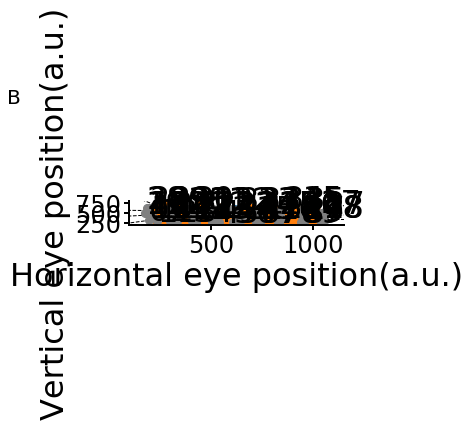

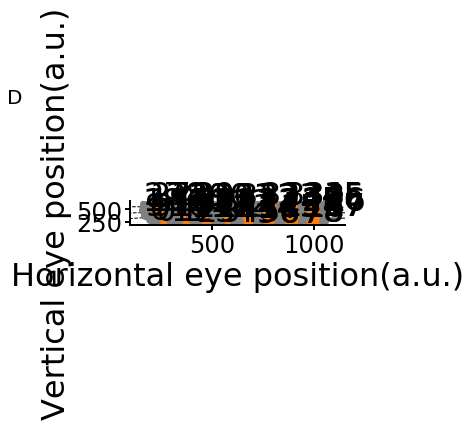

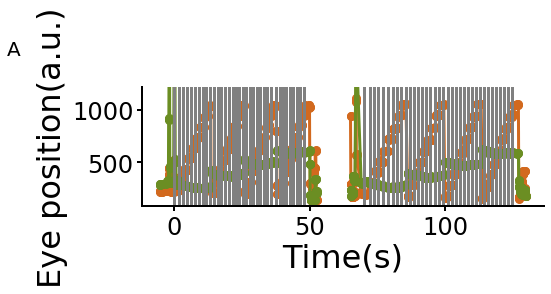

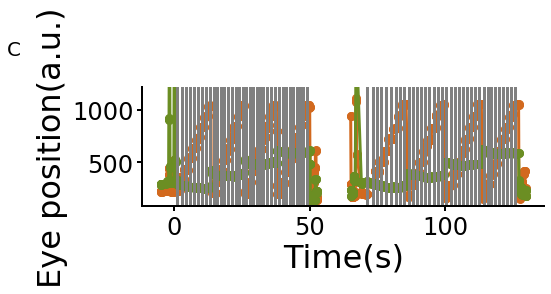

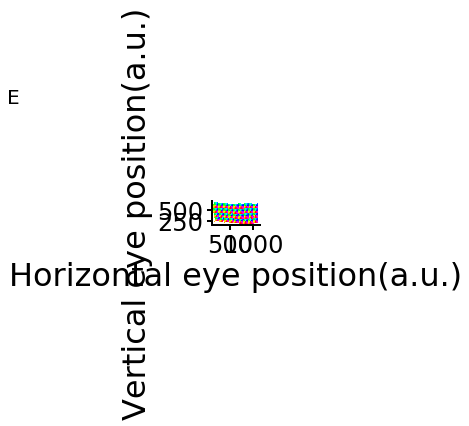

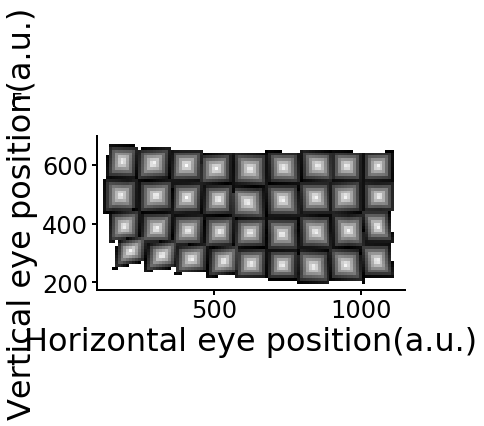

In [9]:
unused = calibrate(data[-2],eye_fix_saccs[-2],fnames_game[-2],verbose=True)

In [10]:
eye_corrected,calibration_coordinates = zip(*[calibrate(d,e,f,verbose=False) for d,e,f in 
                                              zip(data,eye_fix_saccs,fnames_game)])

offset:  0.23098828124988804 second
offset:  -0.47587500000009775 second
offset:  0.11746874999989318 second
offset:  -3.285100341796911 second
offset:  -0.47794140625009374 second
offset:  -0.6789492187500954 second
offset:  0.06835937499989445 second
offset:  -2.3602880859375563 second
offset:  -1.0931933593750836 second
offset:  0.07098437499989041 second


In [11]:
def pad_to_36(x):
    if len(x)<36:
        return np.append(x,[0]*(36-len(x)))
    return x

def get_mouse_tile(mouse_coords):
    top = 507
    bottom = 192
    left = 177
    right = 890
    return (np.floor(9*(mouse_coords[0]-left)/(right-left))+
            9*(np.floor(4*(mouse_coords[1]-bottom)/(top-bottom))))

def get_mouse_hist(line):
    tiles = [get_mouse_tile([int(x) for x in m.split(",")]) 
             for m in line['mouse_coords'].split(";")]
    durations = np.diff([int(t) for t in line['mouse_t'].split(",")])
    return pad_to_36(np.bincount(tiles[1:],weights=durations))

In [12]:
def get_normalized_hist(h,o,u):
    h_unocc=h.astype('float')*(o==0)
    ind=np.sum(h_unocc,axis=1)==0
    h_unocc[ind,:]=u[ind,:]
    h_unocc_norm=h_unocc/np.sum(h_unocc,axis=1)[:,None]
    return h_unocc_norm

In [13]:
eye_hists = [get_all_hists(e,dgame,c,0.5) for e,c,dgame in 
             zip(eye_corrected,calibration_coordinates,data_game)]

eye_hist_norm = [get_normalized_hist(e,o,u) for e,o,u in 
                 zip(eye_hists,occupied_squares,uniform_unocc)]


(128, 36)
(160, 36)
(97, 36)
(117, 36)
(133, 36)
(113, 36)
(138, 36)
(176, 36)
(147, 36)
(102, 36)


In [17]:
model_regressors = np.loadtxt(model_direc + 'fix_depth_unocc_50.txt')
subjects=np.loadtxt(model_direc + '../Move statistics/move_stats_eye.txt')[:,0]

model_regressors_norm = [[get_normalized_hist(model_regressors[np.repeat(subjects==i,36),:][j::36],o,u) 
                          for j in range(36)] 
                         for i,(o,u) in enumerate(zip(occupied_squares,uniform_unocc))]

In [18]:
mouse_hists = [np.vstack([get_mouse_hist(dd) for i,dd in d.iterrows()]) for d in data_game] 

mouse_hist_norm = [get_normalized_hist(m,o,u) for m,o,u in 
                 zip(mouse_hists,occupied_squares,uniform_unocc)]


In [19]:
random_hist_norm = [get_normalized_hist(np.random.uniform(size=o.shape),o,u) for o,u in 
                    zip(occupied_squares,uniform_unocc)]


0.37269264064038127 0.02729961931947966


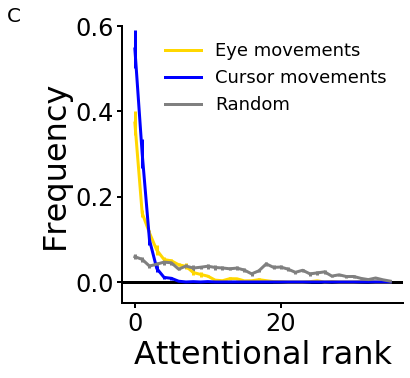

In [20]:
def plot_with_errorbars(fig,ax,x,color,label):
    ax.plot([0,1],[-1,-1],color=color,label=label)
    ax.errorbar(x=range(x.shape[1]),y=np.mean(x,axis=0),
                yerr=np.std(x,axis=0)/np.sqrt(x.shape[0]),color=color)
    ax.axhline(y=0,color='black')
    
fig,ax=plt.subplots()

x = [np.mean(np.argsort(-e*(o==0)-0.001*np.random.uniform(size=e.shape),axis=1)==
             (np.nonzero(a)[1])[:,None],axis=0) 
     for e,o,a in zip(eye_hist_norm,occupied_squares,actual_moves)]
print(np.mean([xx[0] for xx in x]),np.std([xx[0] for xx in x])/np.sqrt(10))

plot_with_errorbars(fig,ax,np.array(x),'gold','Eye movements')

x = [np.mean(np.argsort(-e*(o==0)-0.001*np.random.uniform(size=e.shape),axis=1)==
             (np.nonzero(a)[1])[:,None],axis=0) 
     for e,o,a in zip(mouse_hist_norm,occupied_squares,actual_moves)]

plot_with_errorbars(fig,ax,np.array(x),'blue','Cursor movements')

x = [np.mean(np.argsort(-0.001*np.random.uniform(size=e.shape)*(o==0),axis=1)==
             (np.nonzero(a)[1])[:,None],axis=0) 
     for e,o,a in zip(eye_hist_norm,occupied_squares,actual_moves)]

plot_with_errorbars(fig,ax,np.array(x),'gray','Random')
ax.set_xlabel('Attentional rank')
ax.set_ylabel('Frequency')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.02, 0.9, 'C', horizontalalignment='center',
    verticalalignment='center', transform=fig.transFigure, fontsize = 20)
ax.legend(frameon=False)
ax.set_ylim([-0.05,0.6])
fig.tight_layout()
fig.savefig(fig_direc + 'eyetracking_C.pdf')
plt.show()

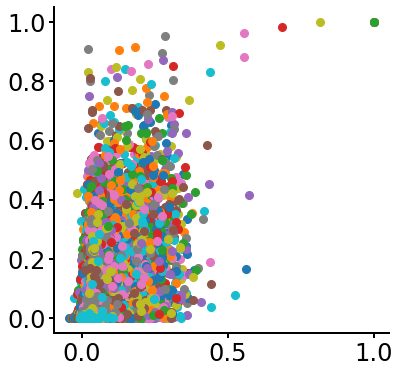

In [21]:
def fit_linear_model(e,u,a,m,o):
    X = np.vstack([(x-u)[o==0].flatten() for x in [a] + m]).T
    y = (e-u)[o==0].flatten()
    model = lin.LinearRegression(fit_intercept=False, normalize=False).fit(X,y)
    ypred = np.dot(X,model.coef_)
    rho = np.corrcoef(ypred,y)[0,1]
    epred = np.zeros_like(e)
    epred[o==0] = ypred + u[o==0]
    return epred,model.coef_,rho
    
    
regression_results = [[fit_linear_model(h,u,a,m[:15],o) for h,u,a,m,o in 
                      zip(hist_norm,uniform_unocc,actual_moves,model_regressors_norm,occupied_squares)] 
                      for hist_norm in [eye_hist_norm,mouse_hist_norm,random_hist_norm]]
    
for r,e in zip(regression_results[0],eye_hist_norm):
    plt.plot(r[0],e,'.')
plt.show()

0.5203158439857921 ± 0.02237008533360191 , p= 3.809257501382012e-09
0.6329869513514614 ± 0.03978252165394886 , p= 1.0680992040520407e-07
0.0775976212357117 ± 0.005200262251856731 , p= 1.8633528964836084e-07


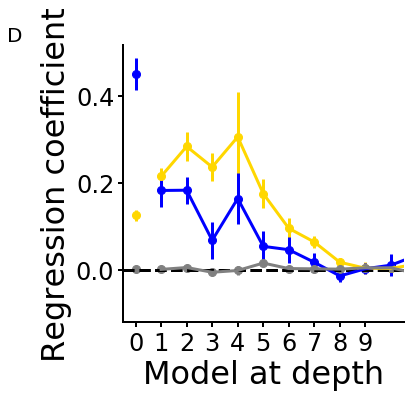

0.450820971409246 ± 0.03723600088148444 , p= 1.11713415251971e-06
0.182122917786849 ± 0.03768505070096216 , p= 0.0013188353222923703
0.18273721321154732 ± 0.030915058657576076 , p= 0.00033103135183970225
0.06733866780799266 ± 0.04287864211984801 , p= 0.17044739737504208
0.1636020209715745 ± 0.0593628684651053 , p= 0.02806112743335559
0.053430464446329304 ± 0.034245624563498375 , p= 0.17296632320030708
0.045699851524428445 ± 0.030308076796385006 , p= 0.1863705591138955
0.016668713606129808 ± 0.02167212760375737 , p= 0.48415349180373357
-0.014742933483382603 ± 0.012965467144345011 , p= 0.3087644543177336
0.0018097809435917254 ± 0.012754979376106063 , p= 0.8958848551999881
0.010088485830814403 ± 0.025664202020070307 , p= 0.7178369961577011
0.032598531000794226 ± 0.0216010210927365 , p= 0.1860335470592519
-0.050066238027345854 ± 0.042425649194498934 , p= 0.29189881178625615
-0.011404043135511398 ± 0.014782303284625037 , p= 0.4828650875371646
0.008828102649056419 ± 0.019237733459305864 , p=

In [56]:
def print_stats(x):
    print(np.mean(x),"±",np.std(x)/np.sqrt(np.size(x)),", p=", sts.ttest_1samp(x,popmean=0).pvalue)

def plot_betas(fig,ax,b,color):
    x=range(b.shape[1])
    y=np.mean(b,axis=0)
    yerr=np.std(b,axis=0)/np.sqrt(np.shape(b)[0])
    ax.errorbar(x=0,y=y[0],yerr=yerr[0],color=color)
    ax.plot(x,y,'.',color=color)
    ax.errorbar(x=x[1:],y=y[1:],yerr=yerr[1:],color=color)

fig,ax=plt.subplots()
for r,color in zip(regression_results,['gold','blue','gray']):
    plot_betas(fig,ax,np.vstack([rr[1] for rr in r]),color)
    ax.axhline(y=0,linestyle='dashed',color = 'black')
    print_stats([rr[2] for rr in r])
    
ax.set_xlabel('Model at depth')
ax.set_xticks(range(10))
ax.set_xlim([-0.5,10.5])
ax.set_ylabel('Regression coefficient')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.02, 0.9, 'D', horizontalalignment='center',
    verticalalignment='center', transform=fig.transFigure, fontsize = 20)

fig.tight_layout()
fig.savefig(fig_direc + 'eyetracking_D.pdf')
plt.show()

for j in range(16):
    print_stats([regression_results[1][i][1][j] for i in range(10)])


In [50]:
def get_eye_trace(i,n):
    t = data_game[i]['timestamp'][n]
    dt = data_game[i]['rt'][n]/1000+0.5
    
    e=eye_corrected[i]
    etdt = e[np.nonzero(e[:,0]>t)[0][0]-1:np.nonzero(e[:,0]<(t+dt))[0][-1]+1,:]
    
    if len(etdt)>1:
        return {'durations' : [etdt[1,0]-t] + list(np.diff(etdt[1:,0])) + [t+dt-etdt[-1,0]],
                'board_coords' : np.array([get_board_coords(eye_coords[1:],np.array(calibration_coordinates[i])) 
                                           for eye_coords in etdt])}
    else:
        return {'durations' : [], 'board_coords' : np.array([])}

In [51]:
eye_traces = [[get_eye_trace(i,n) for n,_ in enumerate(data_game[i]['timestamp'])] for i,_ in enumerate(data_game)]

In [54]:
import pickle
with open(direc + 'Eye movements/eye_corrected.p','wb') as f:
    pickle.dump(eye_corrected,f)
with open(direc + 'Eye movements/data_game.p','wb') as f:
    pickle.dump(data_game,f)
with open(direc + 'Eye movements/eye_traces.p','wb') as f:
    pickle.dump(eye_traces,f)
with open(direc + 'Eye movements/regression_results.p','wb') as f:
    pickle.dump(regression_results,f)
with open(direc + 'Eye movements/eye_hist_norm.p','wb') as f:
    pickle.dump(eye_hist_norm,f)
